In [1]:
# Imports
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Data Preparation
# I already had the dataset zip uploaded to my Google Drive
# in a folder named 'denoising'
local_zip = '/content/drive/MyDrive/denoising/denoising-dirty-documents.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/denoising/data')

zipfiles = ['train.zip', 'train_cleaned.zip', 'test.zip']
for zf in zipfiles:
    zip_ref = zipfile.ZipFile(os.path.join('/content/drive/MyDrive/denoising/data', zf), 'r')
    zip_ref.extractall('/content/drive/MyDrive/denoising/data')
zip_ref.close()

train_path = '/content/drive/MyDrive/denoising/data/train/'
train_cleaned_path = '/content/drive/MyDrive/denoising/data/train_cleaned/'
test_path  = '/content/drive/MyDrive/denoising/data/test/'

In [4]:
X_train = []
y_train = []
X_test = []

# Get the images into the required format
# Image loading, resizing and normalization

# Training noisy images
for img_file in os.listdir(train_path):
    img_path = os.path.join(train_path, img_file)
    img = load_img(img_path, color_mode = 'grayscale', target_size = (420, 540))
    img = img_to_array(img).astype('float32')/255
    X_train.append(img)
    
# Training cleaned images
for img_file in os.listdir(train_cleaned_path):
    img_path = os.path.join(train_cleaned_path, img_file)
    img = load_img(img_path, color_mode = 'grayscale', target_size = (420, 540))
    img = img_to_array(img).astype('float32')/255
    y_train.append(img)

# Testing images
for img_file in os.listdir(test_path):
    img_path = os.path.join(test_path, img_file)
    img = load_img(img_path, color_mode = 'grayscale', target_size = (420, 540))
    img = img_to_array(img).astype('float32')/255
    X_test.append(img)

In [5]:
# Convert image lists into numpy arrays so they can be used by the model
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

In [6]:
# Verify that all images have been read 
# First dimension indicates size of array
X_train.shape, y_train.shape, X_test.shape

((144, 420, 540, 1), (144, 420, 540, 1), (72, 420, 540, 1))

In [17]:
# Data Augmentations using imgaug
# Ref: https://imgaug.readthedocs.io/en/latest/source/examples_basics.html#a-standard-use-case

'''
seq = iaa.Sequential([
    iaa.Crop(px=(5, 20)), # crop images from each side by 5 to 20px randomly
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)), # blur images with a sigma of 0 to 1.5
    iaa.Rot90((1,3)) # random rotation between 90, 180, 270 degrees
])

Apply the augmentation
X_train = seq(images=X_train)
y_train = seq(images=y_train)
'''

# Tried to use this, but the results were very bad. Unsure why the model is getting
# confused. Keeping it here for future reference.

In [79]:
# Model Definition
# Ref: https://www.tensorflow.org/tutorials/generative/autoencoder
# I tried the class-based approach mentioned here, but this does not let
# me see the model summary properly, nor does it show up when I try to
# plot the model architecture diagram - it only shows me 2 layers
# as encoder and decoder. So, had to use the link below to generate the
# summary and architecture diagram correctly.

# Ref2: https://www.kaggle.com/vikramtiwari/autoencoders-using-tf-keras-mnist

def denoiser():
    input_layer = tf.keras.layers.Input(shape=(420, 540, 1))
    
    # Encoder - Responsible for compression of the image
    # into its lowest possible format
    x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Dropout for avoiding overfitting (though may still occur due to small dataset!)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Decoder - Responsible for reconstruction of the image
    # without anomalies / noise
    # Convolution layers are in reverse order of the Encoder
    x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    output_layer = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile the model with Adam optimizer and MSE loss (for Kaggle submission)
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model

In [23]:
# Get the autoencoder model object
autoencoder = denoiser()

# Get the model summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 420, 540, 48)      480       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 420, 540, 72)      31176     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 420, 540, 144)     93456     
_________________________________________________________________
batch_normalization_4 (Batch (None, 420, 540, 144)     576       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 210, 270, 144)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 210, 270, 144)     0   

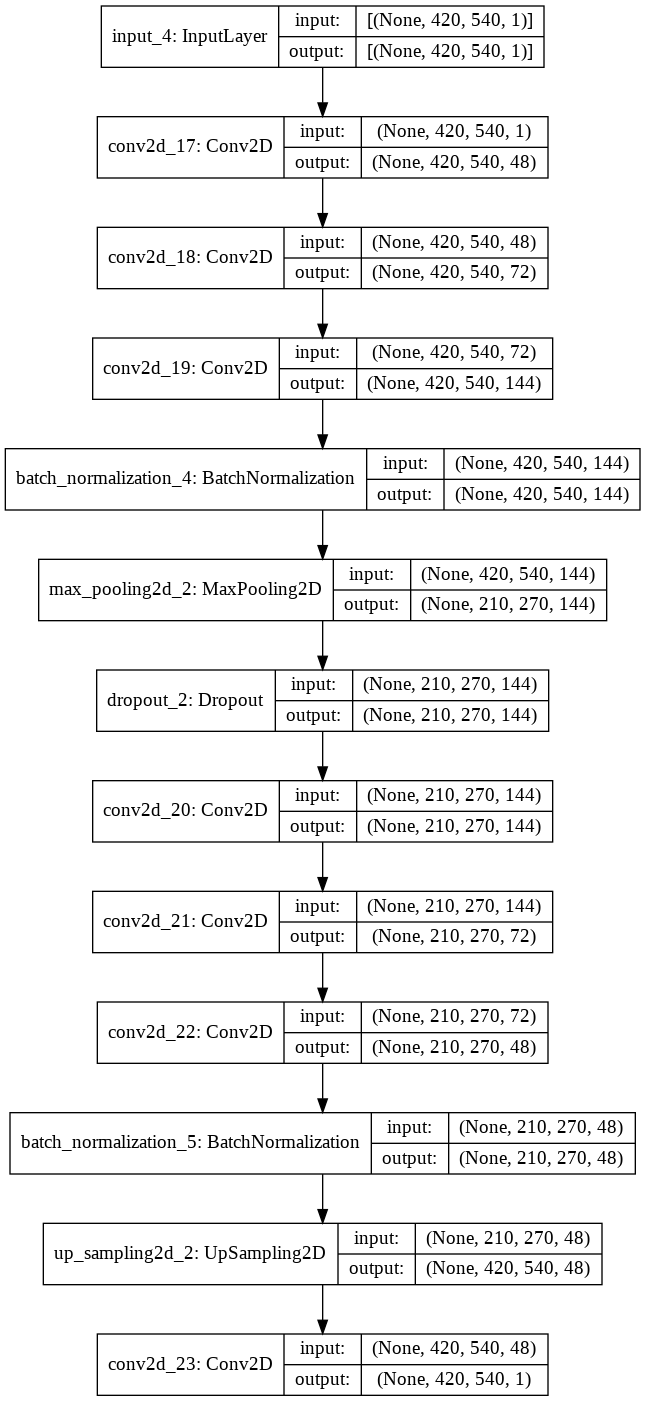

In [27]:
# Get the model architecture diagram

from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
# Training
# 200 Epochs with early stopping callback 
# Stops training when loss has not improved for more than 10 epochs
# Batch size will need to be reduced depending on hardware
callback = EarlyStopping(monitor='loss', patience=10)
history = autoencoder.fit(
                    X_train,
                    y_train,
                    epochs=200,
                    batch_size=16,
                    verbose=1,
                    callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 15s 2s/step - loss: 0.1727 - mae: 0.3300
Epoch 2/200
9/9 [==============================] - 15s 2s/step - loss: 0.0646 - mae: 0.1896
Epoch 3/200
9/9 [==============================] - 15s 2s/step - loss: 0.0464 - mae: 0.1553
Epoch 4/200
9/9 [==============================] - 15s 2s/step - loss: 0.0376 - mae: 0.1341
Epoch 5/200
9/9 [==============================] - 14s 2s/step - loss: 0.0307 - mae: 0.1184
Epoch 6/200
9/9 [==============================] - 14s 2s/step - loss: 0.0272 - mae: 0.1106
Epoch 7/200
9/9 [==============================] - 15s 2s/step - loss: 0.0230 - mae: 0.1013
Epoch 8/200
9/9 [==============================] - 15s 2s/step - loss: 0.0201 - mae: 0.0957
Epoch 9/200
9/9 [==============================] - 15s 2s/step - loss: 0.0166 - mae: 0.0897
Epoch 10/200
9/9 [==============================] - 15s 2s/step - loss: 0.0148 - mae: 0.0820
Epoch 11/200
9/9 [==============================] - 15s 2s/step - loss: 0.0127 

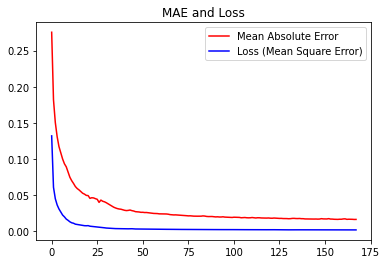

In [25]:
# Plotting MSE Loss and MAE
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'r', label='Mean Absolute Error')
plt.plot(epochs, loss, 'b', label='Loss (Mean Square Error)')
plt.title('MAE and Loss')
plt.legend()

plt.show()

In [64]:
# Get predicted (denoised) output for a few training samples
decoded_imgs = autoencoder(X_train[11:14]).numpy()
test_imgs = os.listdir(train_path)[11:14]

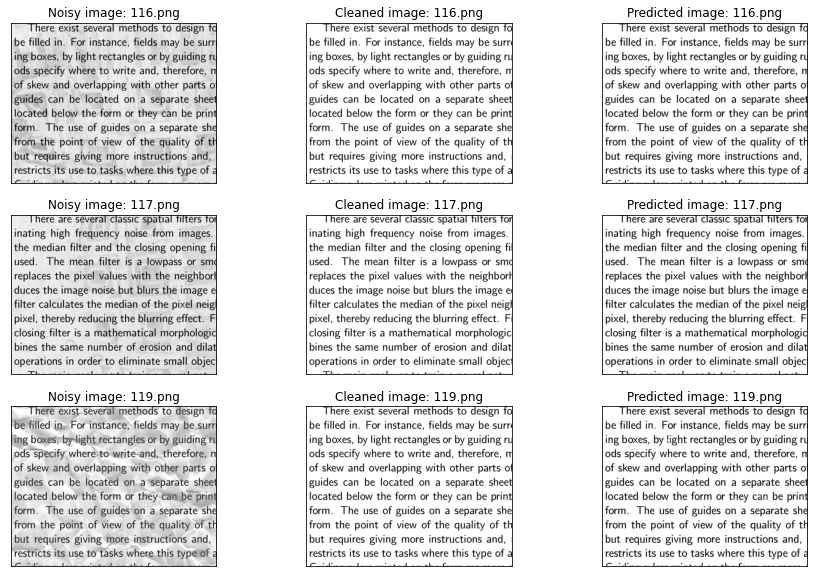

In [70]:
# Plot training sample outputs

fig, ax = plt.subplots(3, 3, figsize=(15,10))

j = 11

for i in range(3):

    ax[i][0].imshow(tf.squeeze(X_train[j]), cmap='gray')
    ax[i][0].set_title('Noisy image: {}'.format(test_imgs[i]))

    ax[i][1].imshow(tf.squeeze(y_train[j]), cmap='gray')
    ax[i][1].set_title('Cleaned image: {}'.format(test_imgs[i]))

    j+=1
    
    ax[i][2].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    ax[i][2].set_title('Predicted image: {}'.format(test_imgs[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    ax[i][2].get_xaxis().set_visible(False)
    ax[i][2].get_yaxis().set_visible(False)

In [71]:
# Get predicted (denoised) output for a few training samples
decoded_imgs = autoencoder(X_test[11:14]).numpy()
test_imgs = os.listdir(test_path)[11:14]

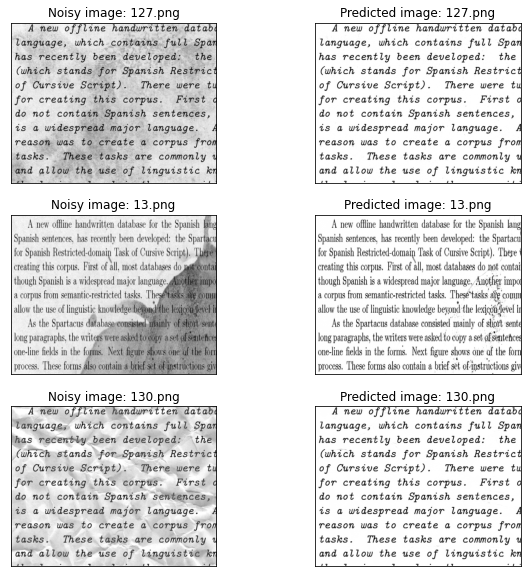

In [73]:
# Plot testing data sample outputs

fig, ax = plt.subplots(3, 2, figsize=(10,10))

j = 11

for i in range(3):

    ax[i][0].imshow(tf.squeeze(X_test[j]), cmap='gray')
    ax[i][0].set_title('Noisy image: {}'.format(test_imgs[i]))

    j+=1
    
    ax[i][1].imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    ax[i][1].set_title('Predicted image: {}'.format(test_imgs[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)

In [75]:
# Test on Test Set
preds = autoencoder.predict(X_test)
print(preds.shape)

(72, 420, 540, 1)


In [76]:
# Read the test images and resize them
import cv2
for img in preds:
    img = cv2.resize(img, (420, 540))

In [77]:
# Export to the required CSV format for Kaggle
import glob
import pandas as pd

# Google drive test images location
TEST_IMAGES = glob.glob('/content/drive/MyDrive/denoising/data/test/*.png')

# Columns for Kaggle submission format
ids = []
vals = []

for idx, filepath in enumerate(TEST_IMAGES):

    # Read the test image from test folder
    filename = os.path.basename(filepath)
    imgid = int(filename[:-4])
    test_img = cv2.imread(filepath, 0)
    img_shape = test_img.shape

    # Resize each predicted image to the original image size
    preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))

    # Iterate through pixel rows
    for r in range(img_shape[0]):

        # Iterate through pixel columns
        for c in range(img_shape[1]):

            # Create the ID
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))

            # Get pixel value at index (row, column)
            vals.append(preds_reshaped[r, c])

# Generate dataframe from the two lists and convert to CSV
pd.DataFrame({'id': ids, 'value': vals}).to_csv('/content/drive/MyDrive/denoising/submission3.csv', index=False)

In [78]:
# Save Model
autoencoder.save('/content/drive/MyDrive/denoising/saved-autoenc-final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/denoising/saved-autoenc-final/assets
